# How AI Pays Attention — Spotlights, Context, and Positional Cues
## Cracking the Code | Episode 3

This notebook explores:
- Positional Encodings: Sinusoidal, Learned, Rotary
- Attention Mechanisms: Self, Cross, Masked, Causal, Soft, Hard, Local
- Multi-head Attention
- Real Attention Heatmaps using PyTorch


In [5]:
# Import dependencies
import torch
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

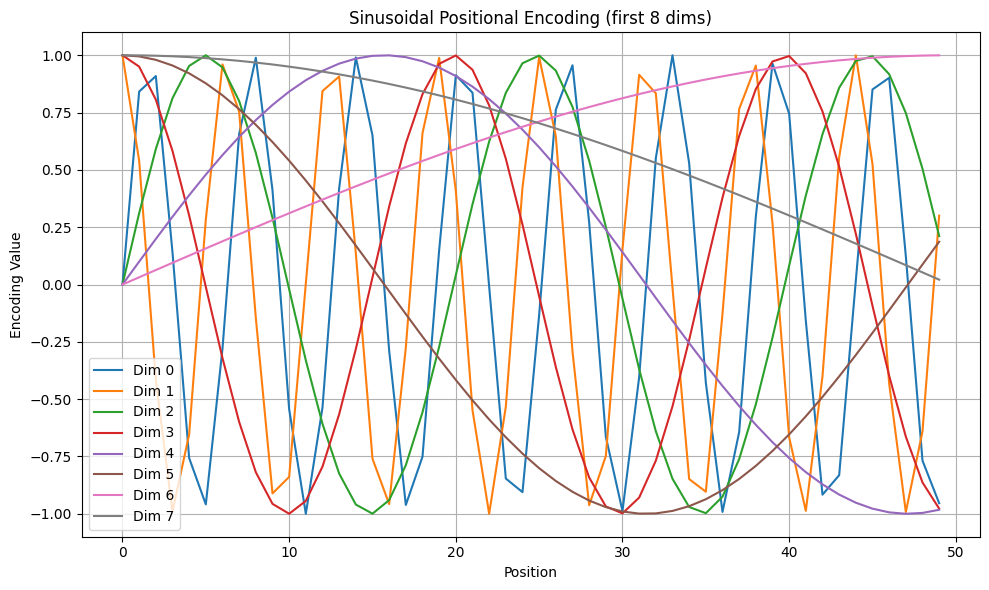

In [6]:
# Sinusoidal Positional Encoding
class SinusoidalPE(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

def visualize_positional_encoding(pe_module, num_positions=50, dims_to_plot=8):
    pe_tensor = pe_module.pe[0, :num_positions].detach().numpy()
    plt.figure(figsize=(10, 6))
    for i in range(dims_to_plot):
        plt.plot(pe_tensor[:, i], label=f"Dim {i}")
    plt.title("Sinusoidal Positional Encoding (first 8 dims)")
    plt.xlabel("Position")
    plt.ylabel("Encoding Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize
d_model = 16
pe_module = SinusoidalPE(d_model=d_model, max_len=100)
visualize_positional_encoding(pe_module)

## Learned Positional Encoding

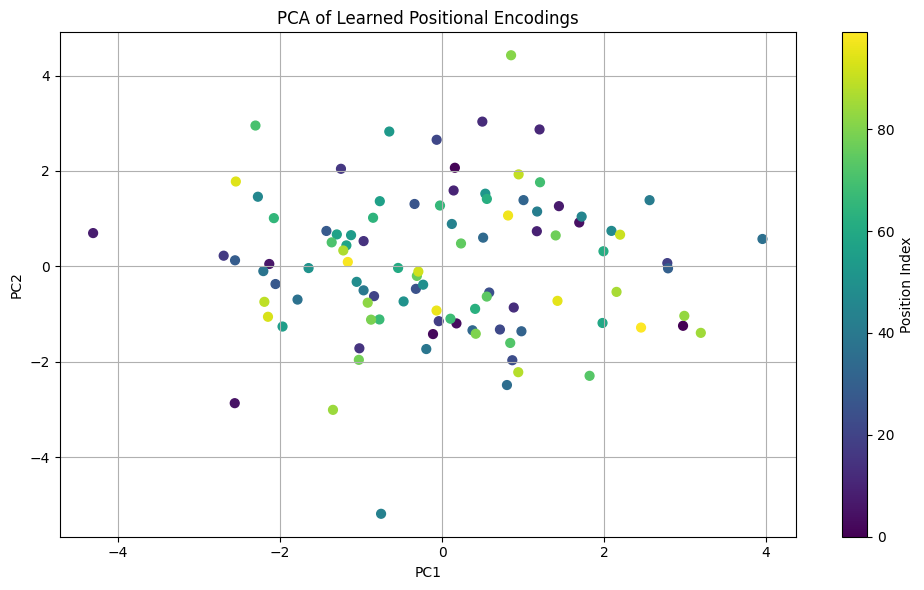

In [7]:
class LearnedPE(torch.nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = torch.nn.Embedding(max_len, d_model)
        self.max_len = max_len

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        return x + self.pe(positions)

# Define and initialize learned positional encoding module
d_model = 32
max_len = 100
pe_learned = LearnedPE(max_len=max_len, d_model=d_model)

# Extract positional vectors
with torch.no_grad():
    learned_weights = pe_learned.pe.weight.cpu().numpy()  # Shape: (max_len, d_model)

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(learned_weights)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=range(max_len), cmap='viridis', s=40)
plt.colorbar(label='Position Index')
plt.title("PCA of Learned Positional Encodings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Rotary Positional Encoding (RoPE - conceptual version)
### Actual rotary usage is more low-level and tied to model internals. Here's a simplified transformation visual

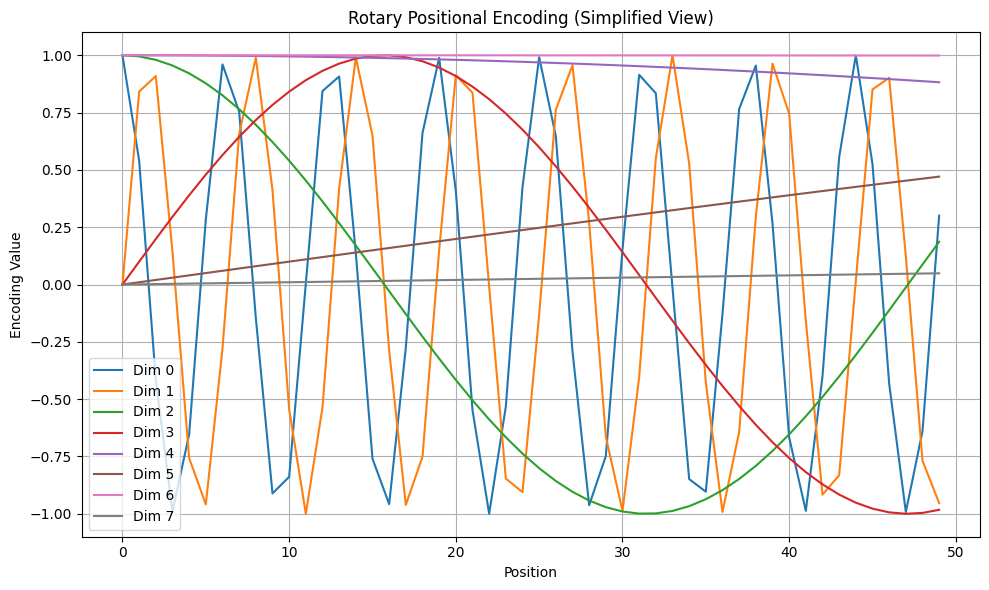

In [3]:
import numpy as np
def visualize_rotary_embedding(dim=8, positions=50):
    pos = torch.arange(positions).unsqueeze(1)
    freqs = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
    angles = pos * freqs
    pe = torch.zeros(positions, dim)
    pe[:, 0::2] = torch.cos(angles)
    pe[:, 1::2] = torch.sin(angles)

    plt.figure(figsize=(10, 6))
    for i in range(dim):
        plt.plot(pe[:, i], label=f"Dim {i}")
    plt.title("Rotary Positional Encoding (Simplified View)")
    plt.xlabel("Position")
    plt.ylabel("Encoding Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_rotary_embedding()

## Multi-Head Attention + Heatmap (Single Head)

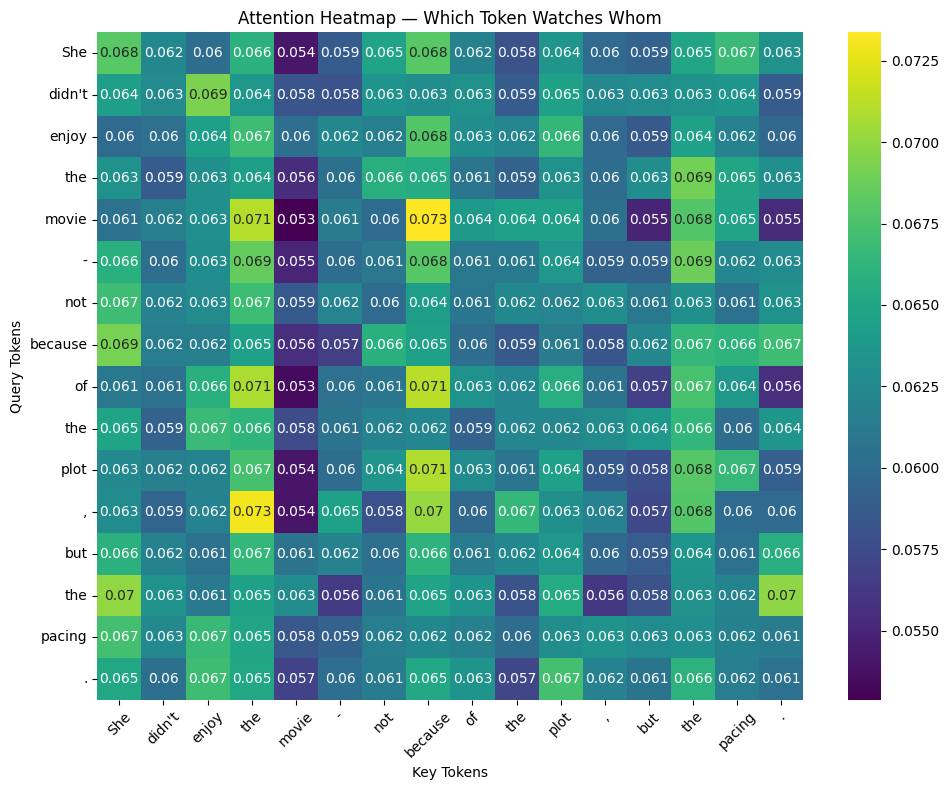

In [8]:
import torch.nn as nn

tokens = ["She", "didn't", "enjoy", "the", "movie", "-", "not", "because", "of", "the", "plot", ",", "but", "the", "pacing", "."]
seq_len = len(tokens)
embed_dim = 16
num_heads = 1

x = torch.rand(seq_len, 1, embed_dim)
mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=False)
output, attn_weights = mha(x, x, x)
weights = attn_weights[0].detach().numpy()

import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 8))
sns.heatmap(weights, xticklabels=tokens, yticklabels=tokens, cmap='viridis', annot=True)
plt.title("Attention Heatmap — Which Token Watches Whom")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cross-Attention
Cross-attention is used when queries (Q) come from a different source than keys (K) and values (V).
Used in encoder-decoder architectures like in translation tasks.


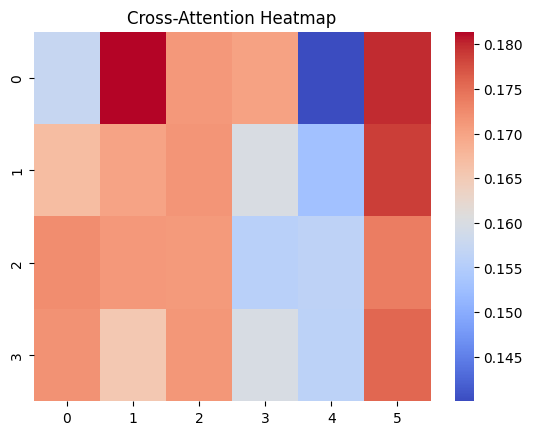

In [9]:
# Example: Cross Attention Setup
query = torch.rand(1, 4, embed_dim)   # e.g., decoder input
key_value = torch.rand(1, 6, embed_dim)  # e.g., encoder output

mha_cross = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1, batch_first=True)
out_cross, attn_cross = mha_cross(query, key_value, key_value)
sns.heatmap(attn_cross[0].detach().numpy(), cmap='coolwarm')
plt.title("Cross-Attention Heatmap")
plt.show()

## Masked and Causal Attention
Masks prevent tokens from attending to future positions — essential for autoregressive models (like GPT).


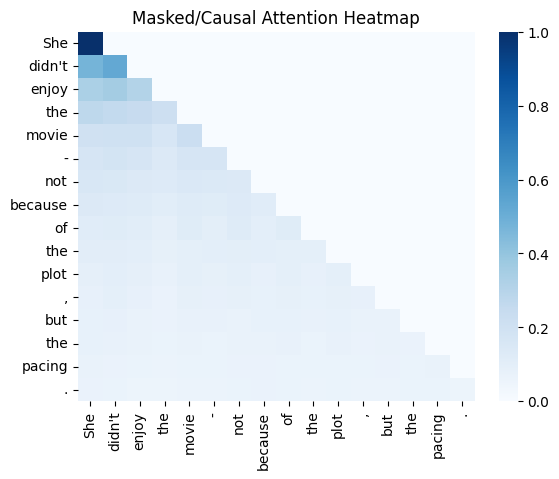

In [10]:
# Masked Attention — Prevent future token access
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
mask = mask.masked_fill(mask == 1, float('-inf'))

mha_masked = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1, batch_first=False)
output_masked, attn_masked = mha_masked(x, x, x, attn_mask=mask)
sns.heatmap(attn_masked[0].detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap='Blues')
plt.title("Masked/Causal Attention Heatmap")
plt.show()

## Soft vs. Hard vs. Local Attention
- **Soft Attention**: Weighted average over all positions (standard Transformer).
- **Hard Attention**: Samples discrete positions (non-differentiable, used in image captioning).
- **Local Attention**: Attends to a fixed window (e.g., [-2, +2] neighbors).

Here's a toy visualization of Local Attention:

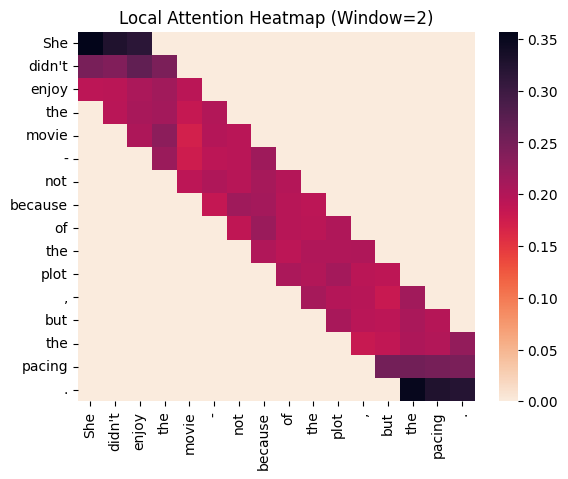

In [11]:
# Local Attention (Window = 2)
window = 2
local_mask = torch.zeros(seq_len, seq_len)
for i in range(seq_len):
    for j in range(seq_len):
        if abs(i - j) > window:
            local_mask[i, j] = float('-inf')

output_local, attn_local = mha(x, x, x, attn_mask=local_mask)
sns.heatmap(attn_local[0].detach().numpy(), xticklabels=tokens, yticklabels=tokens, cmap='rocket_r')
plt.title("Local Attention Heatmap (Window=2)")
plt.show()

## Real Attention Map from DistilBERT (HuggingFace)
This example loads a pretrained model and visualizes token-to-token attention from an intermediate layer.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


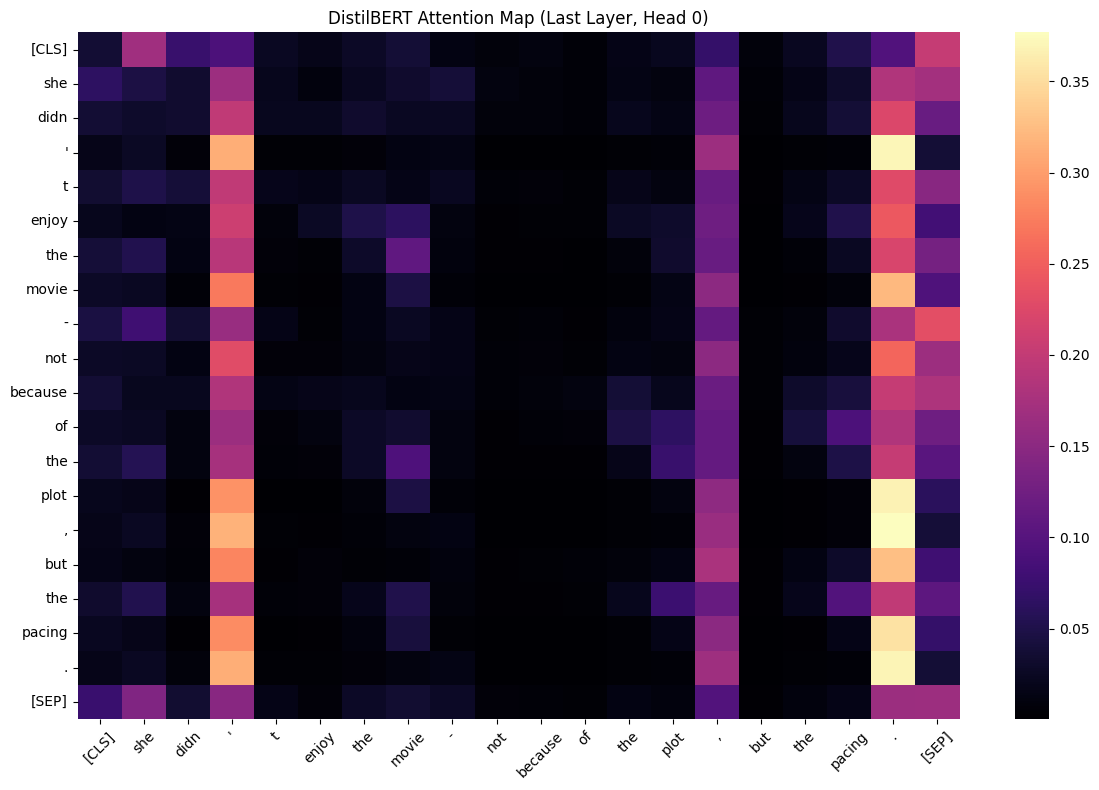

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

sentence = "She didn't enjoy the movie - not because of the plot, but the pacing."
inputs = tokenizer(sentence, return_tensors="pt")
outputs = model(**inputs)
attention = outputs.attentions[-1]  # last layer

attn_matrix = attention[0][0].detach().numpy()  # head 0
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

plt.figure(figsize=(12, 8))
sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap='magma', annot=False)
plt.title("DistilBERT Attention Map (Last Layer, Head 0)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()